# Dimension reduction
Ref: [link](https://userguide.mdanalysis.org/stable/examples/analysis/reduced_dimensions/README.html)

A molecular dynamics trajectory with N atoms can be considered a path through 3N-dimensional molecular configuration space. It remains difficult to extract important dynamics or compare trajectory similarity from such a high-dimensional space. However, collective motions and physically relevant states can often be effectively described with low-dimensional representations of the conformational space explored over the trajectory. MDAnalysis implements two methods for dimensionality reduction.

**Principal component analysis** is a common linear dimensionality reduction technique that maps the coordinates in each frame of your trajectory to a linear combination of orthogonal vectors. The vectors are called principal components, and they are ordered such that the first principal component accounts for the most variance in the original data (i.e. the largest uncorrelated motion in your trajectory), and each successive component accounts for less and less variance. Trajectory coordinates can be transformed onto a lower-dimensional space (essential subspace) constructed from these principal components in order to compare conformations. Your trajectory can also be projected onto each principal component in order to visualise the motion described by that component.

**Diffusion maps** are a non-linear dimensionality reduction technique that embeds the coordinates of each frame onto a lower-dimensional space, such that the distance between each frame in the lower-dimensional space represents their “diffusion distance”, or similarity. It integrates local information about the similarity of each point to its neighours, into a global geometry of the intrinsic manifold. This means that this technique is not suitable for trajectories where the transitions between conformational states is not well-sampled (e.g. replica exchange simulations), as the regions may become disconnected and a meaningful global geometry cannot be approximated. Unlike PCA, there is no explicit mapping between the components of the lower-dimensional space and the original atomic coordinates; no physical interpretation of the eigenvectors is immediately available.

In [1]:
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import MDAnalysis as mda

from MDAnalysis.tests.datafiles import PSF, DCD
from MDAnalysis.analysis import pca, align
# import nglview as nv


%matplotlib inline
# suppress some MDAnalysis warnings about writing PDB files
warnings.filterwarnings('ignore')

## Principal component analysis of a trajectory
Here we compute the principal component analysis of a trajectory.

In [2]:
# loading trajectory
u = mda.Universe(PSF, DCD)

In MDAnalysis, the method implemented in the PCA class is as follows:

1. Optionally align each frame in your trajectory to the first frame.

2. Construct a 3N x 3N covariance for the N atoms in your trajectory. Optionally, you can provide a mean; otherwise the covariance is to the averaged structure over the trajectory.

3. Diagonalise the covariance matrix. The eigenvectors are the principal components, and their eigenvalues are the associated variance.

4. Sort the eigenvalues so that the principal components are ordered by variance.

### PCA analysis

In [3]:
aligner = align.AlignTraj(u, u, select='backbone',
                          in_memory=True).run()

You can choose how many principal components to save from the analysis with `n_components`. The default value is `None`, which saves all of them. You can also pass a `mean` reference structure to be used in calculating the covariance matrix. With the default value of `None`, the covariance uses the mean coordinates of the trajectory.

In [4]:
pc = pca.PCA(u, select='backbone',
             align=True, mean=None,
             n_components=None).run()

The principal components are saved in `pc.p_components`. If you kept all the components, you should have an array of shape (natoms×3,natoms×3).

In [5]:
backbone = u.select_atoms('backbone')
n_bb = len(backbone)
print('There are {} backbone atoms in the analysis'.format(n_bb))
print(pc.p_components.shape)

There are 855 backbone atoms in the analysis
(2565, 2565)


The variance of each principal component is in `pc.variance`. For example, to get the variance explained by the first principal component to 5 decimal places

In [6]:
print(f"PC1: {pc.variance[0]:.5f}")

PC1: 4203.19053


This variance is somewhat meaningless by itself. It is much more intuitive to consider the variance of a principal component as a percentage of the total variance in the data. MDAnalysis also tracks the percentage cumulative variance in `pc.cumulated_variance`. As shown below, the first principal component contains 90.3% the total trajectory variance. The first three components combined account for 96.4% of the total variance.

In [7]:
for i in range(3):
    print(f"Cumulated variance: {pc.cumulated_variance[i]:.3f}")

Cumulated variance: 0.903
Cumulated variance: 0.951
Cumulated variance: 0.964


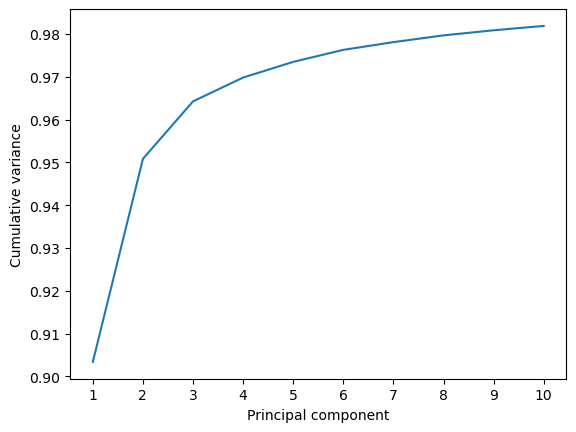

In [8]:
plt.plot(range(1,11), pc.cumulated_variance[:10])
plt.xlabel('Principal component')
plt.xticks(range(1,11))
plt.ylabel('Cumulative variance')
plt.show()

### Visualising projections into a reduced dimensional space

In [9]:
transformed = pc.transform(backbone, n_components=3)
transformed.shape   #(n_frames, n_components)

(98, 3)

In [10]:
df = pd.DataFrame(transformed,
                  columns=['PC{}'.format(i+1) for i in range(3)])
df['Time (ps)'] = df.index * u.trajectory.dt
df.head()

,PC1,PC2,PC3,Time (ps)
0,118.408413,29.088241,15.746624,0.0
1,115.561879,26.786797,14.652498,1.0
2,112.675616,25.038766,12.920274,2.0
3,110.341467,24.306984,11.427098,3.0
4,107.584302,23.464154,11.612104,4.0


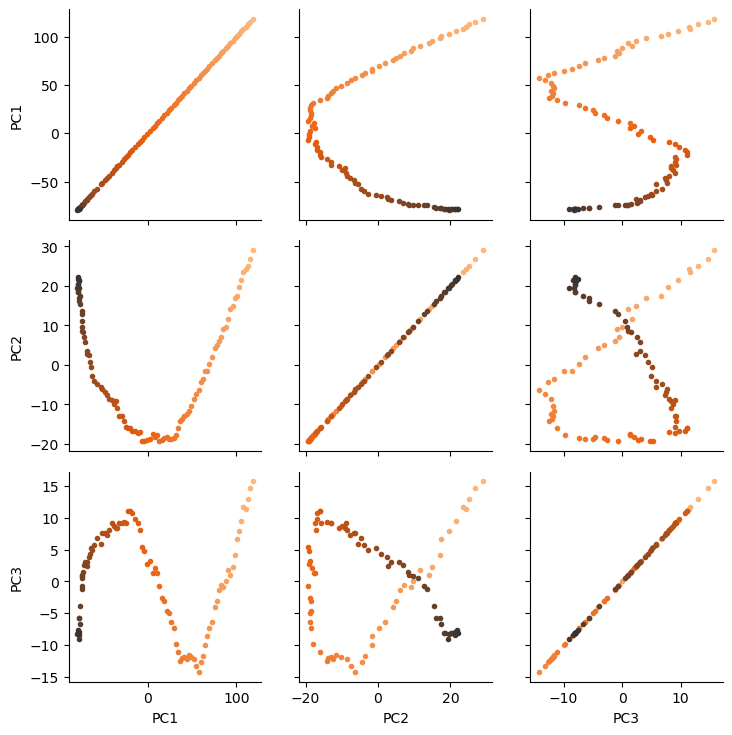

In [11]:
import seaborn as sns

g = sns.PairGrid(df, hue='Time (ps)',
                 palette=sns.color_palette('Oranges_d',
                                           n_colors=len(df)))
g.map(plt.scatter, marker='.')
plt.show()

In [12]:
pc1 = pc.p_components[:, 0]
trans1 = transformed[:, 0]
projected = np.outer(trans1, pc1) + pc.mean.flatten()
coordinates = projected.reshape(len(trans1), -1, 3)

In [13]:
proj1 = mda.Merge(backbone)
proj1.load_new(coordinates, order="fac")

<Universe with 855 atoms>

In [14]:
import nglview as nv
view = nv.show_mdanalysis(proj1.atoms)
view

NGLWidget(max_frame=97)

### Measuring convergence with cosine content
The essential modes of a trajectory usually describe global, collective motions. The cosine content of a principal component can be interpreted to determine whether proteins are transitioning between conformational states. However, random diffusion can also appear to produce collective motion. The cosine content can measure the convergence of a trajectory and indicate poor sampling.

The cosine content of a principal component measures how similar it is to a cosine shape. Values range from 0 (no similarity to a cosine) and 1 (a perfect cosine shape). If the values of the first few principal components are close to 1, this can indicate poor sampling, as the motion of the particles may not be distinguished from random diffusion. Values below 0.7 do not indicate poor sampling.

Below we calculate the cosine content of the first five principal components in the transformed subspace. Note that this is an example only, to dmonstrate how to use the method; the first few principal components of short simulations always represent random diffusion.

In [15]:
for i in range(3):
    cc = pca.cosine_content(transformed, i)
    print(f"Cosine content for PC {i+1} = {cc:.3f}")


Cosine content for PC 1 = 0.960
Cosine content for PC 2 = 0.906
Cosine content for PC 3 = 0.723


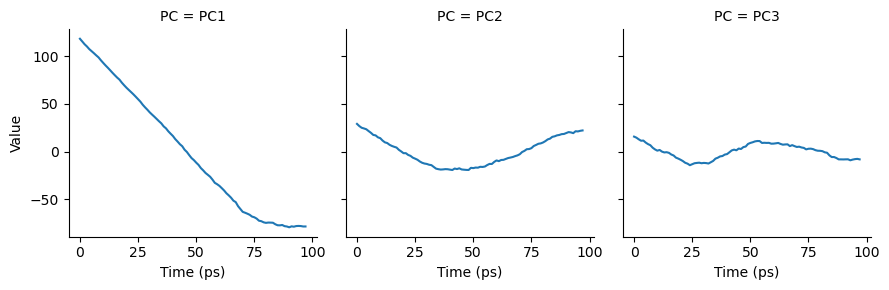

In [16]:
# melt the dataframe into a tidy format
melted = pd.melt(df, id_vars=["Time (ps)"],
                 var_name="PC",
                 value_name="Value")
g = sns.FacetGrid(melted, col="PC")
g.map(sns.lineplot,
      "Time (ps)", # x-axis
      "Value", # y-axis
      ci=None) # no confidence interval
plt.show()


# As can be seen, the cosine content of each component is quite high. 
# If we plot the transformed components over time, we can see that each component does resemble a cosine curve.

## Non-linear dimension reduction to diffusion maps
Here we reduce the dimensions of a trajectory into a diffusion map.

Diffusion maps are a non-linear dimensionality reduction technique that embeds the coordinates of each frame onto a lower-dimensional space, such that the distance between each frame in the lower-dimensional space represents their “diffusion distance”, or similarity. It integrates local information about the similarity of each point to its neighours, into a global geometry of the intrinsic manifold. This means that this technique is not suitable for trajectories where the transitions between conformational states are not well-sampled (e.g. replica exchange simulations), as the regions may become disconnected and a meaningful global geometry cannot be approximated. Unlike principal component analysis, there is no explicit mapping between the components of the lower-dimensional space and the original atomic coordinates; no physical interpretation of the eigenvectors is immediately available. 

In [17]:
u = mda.Universe(PSF, DCD)

In [18]:
import MDAnalysis.analysis.diffusionmap as diffusionmap

# The default distance metric implemented in MDAnalysis’ DiffusionMap class is RMSD.

dmap = diffusionmap.DiffusionMap(u, select='backbone', epsilon=2)
dmap.run()

In [19]:
dmap._eigenvectors[:, 0]

# The first eigenvector in a diffusion map is always essentially all ones (when divided by a constant)

array([-0.10101525, -0.10101525, -0.10101525, -0.10101525, -0.10101525,
       -0.10101525, -0.10101525, -0.10101525, -0.10101525, -0.10101525,
       -0.10101525, -0.10101525, -0.10101525, -0.10101525, -0.10101525,
       -0.10101525, -0.10101525, -0.10101525, -0.10101525, -0.10101525,
       -0.10101525, -0.10101525, -0.10101525, -0.10101525, -0.10101525,
       -0.10101525, -0.10101525, -0.10101525, -0.10101525, -0.10101525,
       -0.10101525, -0.10101525, -0.10101525, -0.10101525, -0.10101525,
       -0.10101525, -0.10101525, -0.10101525, -0.10101525, -0.10101525,
       -0.10101525, -0.10101525, -0.10101525, -0.10101525, -0.10101525,
       -0.10101525, -0.10101525, -0.10101525, -0.10101525, -0.10101525,
       -0.10101525, -0.10101525, -0.10101525, -0.10101525, -0.10101525,
       -0.10101525, -0.10101525, -0.10101525, -0.10101525, -0.10101525,
       -0.10101525, -0.10101525, -0.10101525, -0.10101525, -0.10101525,
       -0.10101525, -0.10101525, -0.10101525, -0.10101525, -0.10

Therefore, when we embed the trajectory onto the dominant eigenvectors, we ignore the first eigenvector. In order to determine which vectors are dominant, we can examine the eigenvalues for a spectral gap: where the eigenvalues stop decreasing constantly in value.



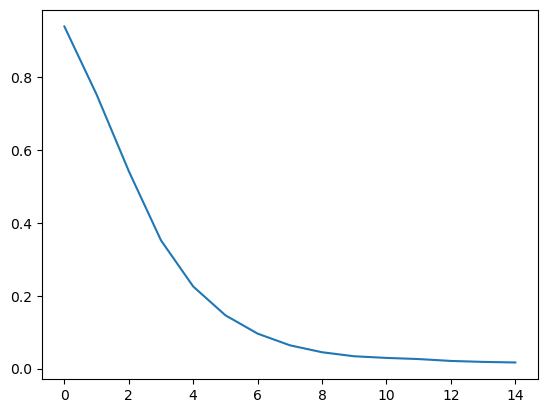

In [20]:
fig, ax = plt.subplots()
ax.plot(dmap.eigenvalues[1:16])

From this plot, we take the first k dominant eigenvectors to be the first five. Below, we transform the trajectory onto these eigenvectors. The `time` argument is the exponent that the eigenvalues are raised to for embedding. As values increase for `time`, more dominant eigenvectors (with lower eigenvalues) dominate the diffusion distance more. The `transform` method returns an array of shape (# frames, # eigenvectors).

In [21]:
transformed = dmap.transform(5,  # number of eigenvectors
                     time=1)
transformed.shape

(98, 5)

In [22]:
df = pd.DataFrame(transformed,
                  columns=['Mode{}'.format(i+2) for i in range(5)])
df['Time (ps)'] = df.index * u.trajectory.dt
df.head()

,Mode2,Mode3,Mode4,Mode5,Mode6,Time (ps)
0,-0.094795,-0.075950,-0.054708,-0.035526,-0.022757,0.0
1,-0.166068,-0.132017,-0.094409,-0.060914,-0.038667,1.0
2,-0.199960,-0.154475,-0.107425,-0.067632,-0.041445,2.0
3,0.228815,0.168694,0.111460,0.067112,0.038469,3.0
4,0.250384,0.171873,0.103407,0.057143,0.028398,4.0


Each of the subplots below illustrates axes of the lower-dimensional embedding of the higher-dimensional data, such that dots (frames) that are close are kinetically close (connected by a large number of short pathways), whereas greater distance indicates states that are connected by a smaller number of long pathways. 

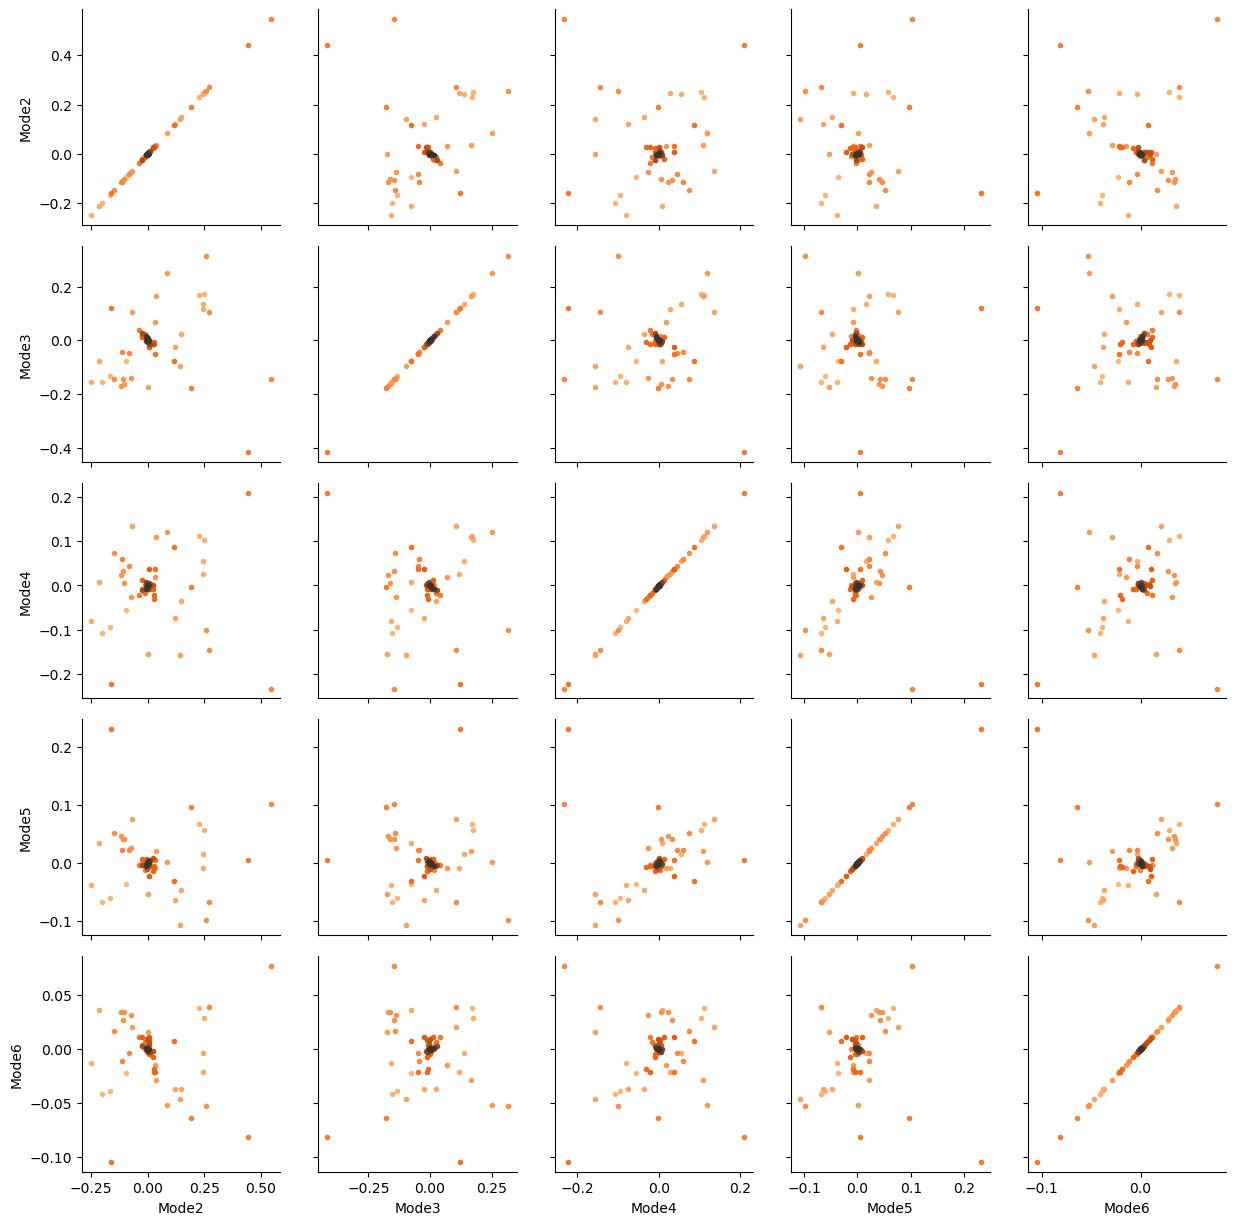

In [23]:
g = sns.PairGrid(df, hue='Time (ps)',
                 palette=sns.color_palette('Oranges_d',
                                           n_colors=len(df)))
g.map(plt.scatter, marker='.')